In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import MetaTrader5 as mt5
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import ta
import itertools

In [2]:
# conecte-se ao MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
  

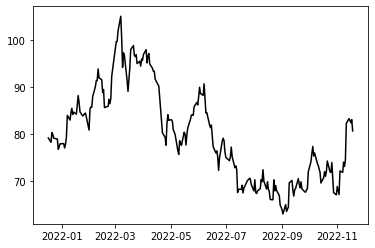

In [3]:
##Coleta de Dados
# Utilizaremos os dados da plataforma de negociação MT5.
#0compra
#1Venda


symbol = "VALE3"

mt5.symbol_select(symbol, True)

date = datetime.today()
    
ativos = mt5.copy_rates_from(symbol,mt5.TIMEFRAME_D1,date,230)

df = pd.DataFrame(ativos)
df["time"] = pd.to_datetime(df["time"],unit="s")
df.set_index('time',inplace=True)

#df.to_excel('C:/Users/BrunoMeazzini/TESTE.xlsx')
#df = df.loc[:'2020-1-1']
plt.plot(df['close'],'k')

In [4]:
#Calculo dos indicadores:

#Indicador 1 - Média móvel do fechamentos

df['MM10']=df['close'].rolling(10).mean()
df['Indicador - MM10'] = np.where(df['MM10'] > df['close'],1,0)

#Preço abaixo da Média 1
#Preço acima da Média 0

In [5]:
#Indicador 2 - Índice de Força Relativa (IFR)
df['IFR']=ta.momentum.RSIIndicator(close=df['close'],window=14).rsi()
df['Indicador - IFR'] = round(df['IFR']/10)





In [6]:
#Indicador 3 - Média móvel do volume

df['MMV10']=df['real_volume'].rolling(10).mean()
df['Indicador - MMV10'] = np.where(df['MMV10'] > df['real_volume'],1,0)

#Volume baixo 1
#Volume alto 0

In [7]:
df=df.dropna()
df['Recompensa'] = df['close'] - df['open']
df['Compra'] = np.where(df['Recompensa']>= 0,1,0)
df['Venda'] = np.where(df['Recompensa']<0,1,0)
df['Target'] = np.where(df['Recompensa'] >=0,0,1)

In [8]:
#Indicadores dia anterior

df['Indicador - MM10 D-1'] = df['Indicador - MM10'].shift(-1).fillna(0).astype('int')
df['Indicador - IFR D-1'] = df['Indicador - IFR'].shift(-1).fillna(0).astype('int')
df['Indicador - MMV10 D-1'] = df['Indicador - MMV10'].shift(-1).fillna(0).astype('int')

#Estado
df['Estado']=df['Indicador - MM10 D-1'].astype('str') + df['Indicador - IFR D-1'].astype('str') + df['Indicador - MMV10 D-1'].astype('str')
df['Estado - IFR/VOL'] = df['Indicador - IFR D-1'].astype('str') + df['Indicador - MMV10 D-1'].astype('str')
df['Estado - IFR/MM10'] = df['Indicador - IFR D-1'].astype('str') + df['Indicador - MM10 D-1'].astype('str')
df['Estado - MM10/VOL'] = df['Indicador - MM10 D-1'].astype('str') + df['Indicador - MMV10 D-1'].astype('str')




In [9]:
#Estados
Estados = pd.DataFrame(set(df['Estado']))
EstadoIFRVOL = pd.DataFrame(set(df['Estado - IFR/VOL']))
EstadoIFRMM = pd.DataFrame(set(df['Estado - IFR/MM10']))
EstadoVOLMM = pd.DataFrame(set(df['Estado - MM10/VOL']))
EstadoIFR = pd.DataFrame(set(df['Indicador - IFR D-1']))
EstadoMM = pd.DataFrame(set(df['Indicador - MM10 D-1']))
EstadoVOL = pd.DataFrame(set(df['Indicador - MMV10 D-1']))

q_table = np.zeros((len(Estados),3))
q_tableIFRVOL = np.zeros((len(EstadoIFRVOL),3))
q_tableIFRMM = np.zeros((len(EstadoIFRMM),3))
q_tableVOLMM = np.zeros((len(EstadoVOLMM),3))
q_tableIFR = np.zeros((len(EstadoIFR),3))
q_tableMM = np.zeros((len(EstadoMM),3))
q_tableVOL = np.zeros((len(EstadoVOL),3))

In [10]:
q_table = pd.DataFrame(q_table,columns=['Comprar','Vender','Estado'])
q_tableIFRVOL = pd.DataFrame(q_tableIFRVOL,columns=['Comprar','Vender','Estado'])
q_tableIFRMM = pd.DataFrame(q_tableIFRMM,columns=['Comprar','Vender','Estado'])
q_tableVOLMM = pd.DataFrame(q_tableVOLMM,columns=['Comprar','Vender','Estado'])
q_tableIFR = pd.DataFrame(q_tableIFR,columns=['Comprar','Vender','Estado'])
q_tableMM = pd.DataFrame(q_tableMM,columns=['Comprar','Vender','Estado'])
q_tableVOL = pd.DataFrame(q_tableVOL,columns=['Comprar','Vender','Estado'])
q_table['Estado'] = Estados
q_tableIFRVOL['Estado'] = EstadoIFRVOL
q_tableIFRMM['Estado'] = EstadoIFRMM
q_tableVOLMM['Estado'] = EstadoVOLMM
q_tableIFR['Estado'] = EstadoIFR
q_tableMM['Estado'] = EstadoMM
q_tableVOL['Estado'] = EstadoVOL

In [11]:
#Função ação
def acao(estado, epsilon,q_table):
  if np.random.random() < epsilon:
    return np.argmax(q_table.loc[(q_table['Estado'] == estado),('Comprar','Vender')])
    
  else: 
    return np.random.randint(2)
    


In [12]:
df

,open,high,low,close,tick_volume,spread,real_volume,MM10,Indicador - MM10,IFR,...,Compra,Venda,Target,Indicador - MM10 D-1,Indicador - IFR D-1,Indicador - MMV10 D-1,Estado,Estado - IFR/VOL,Estado - IFR/MM10,Estado - MM10/VOL
time,,,,,,,,,,,,,,,,,,,,,
2022-01-07,80.40,84.00,79.79,84.00,91293,0,34579100,78.638,0,73.104762,...,1,0,0,0,7,0,070,70,70,00
2022-01-10,82.49,84.27,82.30,83.00,79939,0,24267200,79.023,0,66.858805,...,1,0,0,0,7,0,070,70,70,00
2022-01-11,83.48,85.15,83.31,84.58,75964,0,26910400,79.586,0,71.065247,...,1,0,0,0,7,0,070,70,70,00
2022-01-12,86.49,86.58,84.93,85.50,86401,0,27012100,80.456,0,73.198404,...,0,1,1,0,7,1,071,71,70,01
2022-01-13,84.84,85.23,83.70,84.20,64686,0,22458300,81.151,0,65.814824,...,0,1,1,0,7,1,071,71,70,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11,77.99,82.99,77.21,82.30,200797,0,77607900,71.883,0,68.268265,...,1,0,0,0,7,1,071,71,70,01
2022-11-14,82.39,84.44,81.38,83.31,103217,0,42958000,73.457,0,69.384916,...,1,0,0,0,7,1,071,71,70,01
2022-11-16,83.32,84.77,81.54,82.44,128217,0,32514500,74.991,0,67.191503,...,0,1,1,0,7,1,071,71,70,01


In [13]:
#Funçao recompensa
def recompensa(act, q_atual, pontos,LEARNING_RATE,DISCOUNT):
  
    recompensa_max = abs(pontos)
    if act == 'Comprar':
      q_novo = q_atual + LEARNING_RATE * (pontos + DISCOUNT * recompensa_max - q_atual)
      #q_novo = q_atual+pontos

    elif act == 'Vender':
      q_novo = q_atual + LEARNING_RATE * ((-1*pontos) + DISCOUNT * recompensa_max - q_atual)
      #q_novo = q_atual+(-1*pontos)
      
    else:
      q_novo = 0

    
    return q_novo

In [14]:
#Função de teste da tabela
def teste(q_table, df_teste,INDICADOR):
  result=[]
  pts = 0
  for i in df_teste.index:
    estado = df_teste.loc[i,INDICADOR]
    act = np.argmax(q_table.loc[(q_table['Estado'] == estado),('Comprar','Vender')])
    if act == 0:
      pt = df_teste.loc[i,'Recompensa']
    elif act == 1:
      pt = -1*df_teste.loc[i,'Recompensa']
    else:
      pt = 0
    
    pts = pts+pt
    result.append([i,pts])

  return pd.DataFrame(result,columns=['Data','PTS'])

In [15]:
#Divisão de Treino e Teste
Treino = df[:round(0.40*len(df))]
Teste = df[round(0.40*len(df)):]

In [16]:
#Treinamento final Comparado ao benchmark

#a = teste(q_table,Treino)
#plt.figure(figsize=(20, 4))
#plt.plot(a['Data'],a['PTS'])
#plt.plot(Treino['close']-Treino['close'].iloc[0])
#Teste Final Comparado ao benchmark
#b = teste(q_table,Teste)
#plt.figure(figsize=(20, 4))
#plt.plot(b['Data'],b['PTS'])
#plt.plot(Teste['close']-Teste['close'].iloc[0])

In [17]:

#Treinamento
def q_learning(EPISODES,INDICADOR,epsilon,LEARNING_RATE,DISCOUNT,DADOS,Q_TABLE):
    for n in range(EPISODES):
        for i in DADOS.index:
            state = DADOS.loc[i,INDICADOR]
            Pts = DADOS.loc[i,'Recompensa']
            cvn = acao(state,epsilon,Q_TABLE)

            if cvn == 0:
              cvn='Comprar'
            elif cvn == 1:
              cvn='Vender'
            else:
              cvn='Não Faz Nada'

            q_atual = Q_TABLE.loc[(Q_TABLE['Estado'] == state)][cvn]
            q_novo = recompensa(cvn,q_atual,Pts,LEARNING_RATE,DISCOUNT)
            Q_TABLE.loc[(Q_TABLE['Estado'] == state),cvn]= q_novo
    return Q_TABLE


In [28]:
# Q-Learning settings

LEARNING_RATE = 0.8
DISCOUNT = 0.8
EPISODES = 100
epsilon = 0.75

GERAL = q_learning(EPISODES,'Estado',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_table)
IFRVOL = q_learning(EPISODES,'Estado - IFR/VOL',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableIFRVOL)
IFRMM = q_learning(EPISODES,'Estado - IFR/MM10',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableIFRMM)
VOLMM = q_learning(EPISODES,'Estado - MM10/VOL',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableVOLMM)
IFR = q_learning(EPISODES,'Indicador - IFR D-1',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableIFR)
MM = q_learning(EPISODES,'Indicador - MM10 D-1',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableMM)
VOL = q_learning(EPISODES,'Indicador - MMV10 D-1',epsilon,LEARNING_RATE,DISCOUNT,Treino,q_tableVOL)


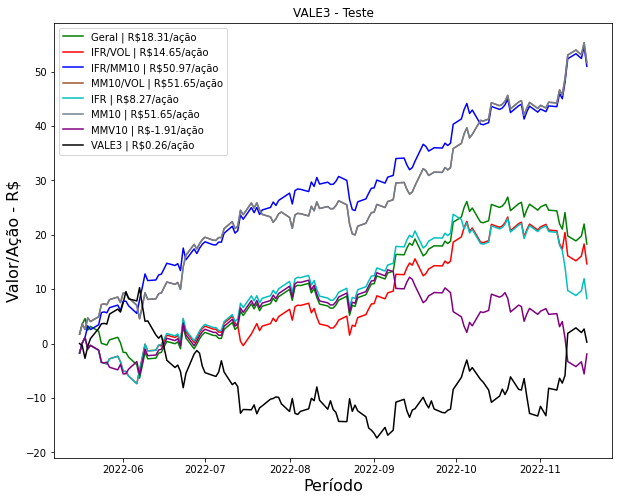

In [30]:
a = teste(GERAL,Teste,'Estado')
resulta = a[-1:]['PTS']
b = teste(IFRVOL,Teste,'Estado - IFR/VOL')
resultb = b[-1:]['PTS']
c = teste(IFRMM,Teste,'Estado - IFR/MM10')
resultc = c[-1:]['PTS']
d = teste(VOLMM,Teste,'Estado - MM10/VOL')
resultd = d[-1:]['PTS']
e = teste(IFR,Teste,'Indicador - IFR D-1')
resulte = e[-1:]['PTS']
f = teste(MM,Teste,'Indicador - MM10 D-1')
resultf = f[-1:]['PTS']
g = teste(VOL,Teste,'Indicador - MMV10 D-1')
resultg = g[-1:]['PTS']
resulth = Teste['close'][-1]-Teste['close'].iloc[0]
plt.figure(figsize=(10, 8))
plt.plot(a['Data'],a['PTS'],'g',label = 'Geral | R$%0.2f/ação' % resulta)
plt.plot(b['Data'],b['PTS'],'r',label='IFR/VOL | R$%0.2f/ação' % resultb)
plt.plot(c['Data'],c['PTS'],'b',label='IFR/MM10 | R$%0.2f/ação' % resultc)
plt.plot(d['Data'],d['PTS'],'sienna',label='MM10/VOL | R$%0.2f/ação' % resultd)
plt.plot(e['Data'],e['PTS'],'c',label='IFR | R$%0.2f/ação' % resulte)
plt.plot(f['Data'],f['PTS'],'slategray',label='MM10 | R$%0.2f/ação' % resultf)
plt.plot(g['Data'],g['PTS'],'purple',label='MMV10 | R$%0.2f/ação' % resultg)
plt.plot(Teste['close']-Teste['close'].iloc[0],'k',label=symbol+ ' | R$%0.2f/ação' % resulth)
plt.xlabel("Período", size = 16)
plt.ylabel("Valor/Ação - R$", size = 16)
plt.title(symbol+" - Teste")
plt.legend(fontsize = 10)
plt.savefig(symbol + ' - Resultado.png', format='png')

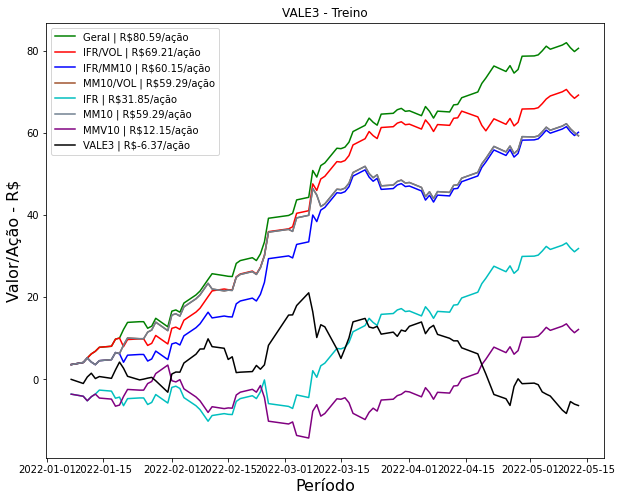

In [31]:
a = teste(GERAL,Treino,'Estado')
resulta = a[-1:]['PTS']
b = teste(IFRVOL,Treino,'Estado - IFR/VOL')
resultb = b[-1:]['PTS']
c = teste(IFRMM,Treino,'Estado - IFR/MM10')
resultc = c[-1:]['PTS']
d = teste(VOLMM,Treino,'Estado - MM10/VOL')
resultd = d[-1:]['PTS']
e = teste(IFR,Treino,'Indicador - IFR D-1')
resulte = e[-1:]['PTS']
f = teste(MM,Treino,'Indicador - MM10 D-1')
resultf = f[-1:]['PTS']
g = teste(VOL,Treino,'Indicador - MMV10 D-1')
resultg = g[-1:]['PTS']
resulth = Treino['close'][-1]-Treino['close'].iloc[0]
plt.figure(figsize=(10, 8))
plt.plot(a['Data'],a['PTS'],'g',label = 'Geral | R$%0.2f/ação' % resulta)
plt.plot(b['Data'],b['PTS'],'r',label='IFR/VOL | R$%0.2f/ação' % resultb)
plt.plot(c['Data'],c['PTS'],'b',label='IFR/MM10 | R$%0.2f/ação' % resultc)
plt.plot(d['Data'],d['PTS'],'sienna',label='MM10/VOL | R$%0.2f/ação' % resultd)
plt.plot(e['Data'],e['PTS'],'c',label='IFR | R$%0.2f/ação' % resulte)
plt.plot(f['Data'],f['PTS'],'slategray',label='MM10 | R$%0.2f/ação' % resultf)
plt.plot(g['Data'],g['PTS'],'purple',label='MMV10 | R$%0.2f/ação' % resultg)
plt.plot(Treino['close']-Treino['close'].iloc[0],'k',label=symbol+ ' | R$%0.2f/ação' % resulth)
plt.xlabel("Período", size = 16)
plt.ylabel("Valor/Ação - R$", size = 16)
plt.title(symbol+" - Treino")
plt.legend(fontsize = 10)
plt.savefig(symbol + ' - Treinamento.png', format='png')

In [21]:
Teste

,open,high,low,close,tick_volume,spread,real_volume,MM10,Indicador - MM10,IFR,...,Compra,Venda,Target,Indicador - MM10 D-1,Indicador - IFR D-1,Indicador - MMV10 D-1,Estado,Estado - IFR/VOL,Estado - IFR/MM10,Estado - MM10/VOL
time,,,,,,,,,,,,,,,,,,,,,
2022-05-16,78.68,80.64,78.52,80.42,64175,0,23366900,79.084,0,42.800686,...,1,0,0,0,4,0,040,40,40,00
2022-05-17,81.85,81.92,78.86,79.99,82378,0,28709800,78.813,0,41.947201,...,0,1,1,1,4,0,140,40,41,10
2022-05-18,78.71,79.25,77.42,77.71,79525,0,29934800,78.489,1,37.659086,...,0,1,1,0,4,1,041,41,40,01
2022-05-19,77.78,80.38,77.47,79.90,65817,0,28351600,78.438,0,43.620864,...,1,0,0,0,5,0,050,50,50,00
2022-05-20,82.01,82.46,80.58,81.34,85492,0,37348500,78.578,0,47.196616,...,0,1,1,0,5,1,051,51,50,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11,77.99,82.99,77.21,82.30,200797,0,77607900,71.883,0,68.268265,...,1,0,0,0,7,1,071,71,70,01
2022-11-14,82.39,84.44,81.38,83.31,103217,0,42958000,73.457,0,69.384916,...,1,0,0,0,7,1,071,71,70,01
2022-11-16,83.32,84.77,81.54,82.44,128217,0,32514500,74.991,0,67.191503,...,0,1,1,0,7,1,071,71,70,01


In [22]:
def teste2(q_table, df_teste,INDICADOR):
  result=[]
  pts = 0
  for i in df_teste.index:
    estado = df_teste.loc[i,INDICADOR]
    act = np.argmax(q_table.loc[(q_table['Estado'] == estado),('Comprar','Vender')])
    if act == 0:
      result.append([0,df_teste.loc[i,INDICADOR],df_teste.loc[i,'Target']])
    elif act == 1:
      result.append([1,df_teste.loc[i,INDICADOR],df_teste.loc[i,'Target']])
    else:
      print('xxxx')
  
  q_table_q = df_teste.groupby([INDICADOR])[['Compra','Venda']].sum()
  q_table_q['Total'] = q_table_q['Compra']+q_table_q['Venda']
  q_table_q['%Compra'] = q_table_q['Venda']/q_table_q['Total']

  result = pd.DataFrame(result,columns=['c/v','Estado','Target'])

  lista= []
  for i in result.index:
    a = result.loc[i,'Estado']
    b = q_table_q.loc[a,'%Compra']
    lista.append(b) 

  result['Probabilidade'] = lista

  return result

In [23]:
a = teste2(GERAL,Teste,'Estado')
b = teste2(IFRVOL,Teste,'Estado - IFR/VOL')
c = teste2(IFRMM,Teste,'Estado - IFR/MM10')
d = teste2(VOLMM,Teste,'Estado - MM10/VOL')
e = teste2(IFR,Teste,'Indicador - IFR D-1')
f = teste2(MM,Teste,'Indicador - MM10 D-1')
g = teste2(VOL,Teste,'Indicador - MMV10 D-1')

#aac = accuracy_score(a['Target'], a['c/v'])
acf_mat = confusion_matrix(a['Target'], a['c/v'])
axxx=a.sort_values(by='Probabilidade',ascending=False)
afpr, atpr, athresholds = roc_curve(axxx['Target'],axxx['Probabilidade'])
aac = roc_auc_score(axxx['Target'],axxx['Probabilidade'])

#bac = accuracy_score(b['Target'], b['c/v'])
bcf_mat = confusion_matrix(b['Target'], b['c/v'])
bxxx=b.sort_values(by='Probabilidade',ascending=False)
bfpr, btpr, bthresholds = roc_curve(bxxx['Target'],bxxx['Probabilidade'])
bac = roc_auc_score(bxxx['Target'],bxxx['Probabilidade'])

#cac = accuracy_score(c['Target'], c['c/v'])
ccf_mat = confusion_matrix(c['Target'], c['c/v'])
cxxx=c.sort_values(by='Probabilidade',ascending=False)
cfpr, ctpr, bthresholds = roc_curve(cxxx['Target'],cxxx['Probabilidade'])
cac = roc_auc_score(cxxx['Target'],cxxx['Probabilidade'])

#dac = accuracy_score(d['Target'], d['c/v'])
dcf_mat = confusion_matrix(d['Target'],d['c/v'])
dxxx=d.sort_values(by='Probabilidade',ascending=False)
dfpr, dtpr, dthresholds = roc_curve(dxxx['Target'],dxxx['Probabilidade'])
dac = roc_auc_score(dxxx['Target'],dxxx['Probabilidade'])

#eac = accuracy_score(e['Target'], e['c/v'])
ecf_mat = confusion_matrix(e['Target'], e['c/v'])
exxx=e.sort_values(by='Probabilidade',ascending=False)
efpr, etpr, ethresholds = roc_curve(exxx['Target'],exxx['Probabilidade'])
eac = roc_auc_score(exxx['Target'],exxx['Probabilidade'])

#fac = accuracy_score(f['Target'], f['c/v'])
fcf_mat = confusion_matrix(f['Target'], f['c/v'])
fxxx=f.sort_values(by='Probabilidade',ascending=False)
ffpr, ftpr, bthresholds = roc_curve(fxxx['Target'],fxxx['Probabilidade'])
fac = roc_auc_score(fxxx['Target'],fxxx['Probabilidade'])

#gac = accuracy_score(g['Target'], g['c/v'])
gcf_mat = confusion_matrix(g['Target'], g['c/v'])
gxxx=g.sort_values(by='Probabilidade',ascending=False)
gfpr, gtpr, gthresholds = roc_curve(gxxx['Target'],gxxx['Probabilidade'])
gac = roc_auc_score(gxxx['Target'],gxxx['Probabilidade'])

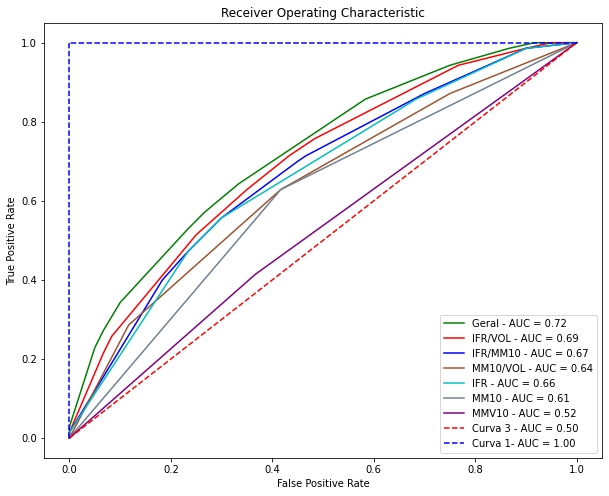

In [32]:
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ac)
plt.plot(afpr, atpr, 'g', label = 'Geral - AUC = %0.2f' % aac)
plt.plot(bfpr, btpr, 'r', label = 'IFR/VOL - AUC = %0.2f' % bac)
plt.plot(cfpr, ctpr, 'b', label = 'IFR/MM10 - AUC = %0.2f' % cac)
plt.plot(dfpr, dtpr, 'sienna', label = 'MM10/VOL - AUC = %0.2f' % dac)
plt.plot(efpr, etpr, 'c', label = 'IFR - AUC = %0.2f' % eac)
plt.plot(ffpr, ftpr, 'slategray', label = 'MM10 - AUC = %0.2f' % fac)
plt.plot(gfpr, gtpr, 'purple', label = 'MMV10 - AUC = %0.2f' % gac)

plt.plot([0, 1], [0, 1],'r--',label = 'Curva 3 - AUC = 0.50')
plt.plot([0, 0], [0, 1],'b--',label = 'Curva 1- AUC = 1.00')
plt.plot([1, 0], [1, 1],'b--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

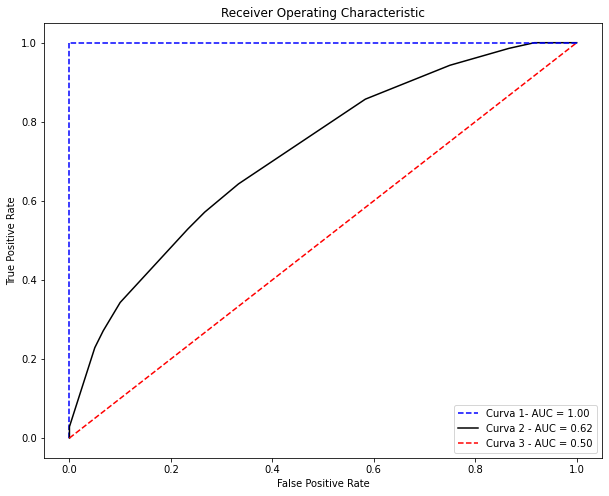

In [25]:
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic')
plt.plot([0, 0], [0, 1],'b--',label = 'Curva 1- AUC = 1.00')
plt.plot(afpr, atpr, 'k', label = 'Curva 2 - AUC = 0.62')

plt.plot([0, 1], [0, 1],'r--',label = 'Curva 3 - AUC = 0.50')

plt.plot([1, 0], [1, 1],'b--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [33]:
MM.to_excel("Q_Learning.xlsx",sheet_name='MM')
GERAL.to_excel("Q_Learning.xlsx",sheet_name='GERAL')

In [34]:
with pd.ExcelWriter('output.xlsx') as writer:  
    MM.to_excel(writer, sheet_name='MM')
    GERAL.to_excel(writer, sheet_name='GERAL')
    VOL.to_excel(writer, sheet_name='VOL')
    IFR.to_excel(writer, sheet_name='IFR')
    VOLMM.to_excel(writer, sheet_name='VOLMM')
    IFRMM.to_excel(writer, sheet_name='IFRMM')
    IFRVOL.to_excel(writer, sheet_name='IFRVOL')